In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.graficar import graficar_serie 
from src.ARIMA_experimento import ARIMA_experimento
from src.evaluar import evaluar_forecast

###  Descomposición de la serie ###
from statsmodels.tsa.seasonal import seasonal_decompose

## Reporte 4
* Ventana de 1665 horas
* Horizonte de 24 horas

In [2]:
ruta_df = 'data/raw_data/coffee.csv'
df = pd.read_csv(ruta_df)  
print(df.shape)
df.head()

(3636, 6)


,date,datetime,cash_type,card,money,coffee_name
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.7,Latte
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.7,Hot Chocolate
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.7,Hot Chocolate
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.9,Americano
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,38.7,Latte


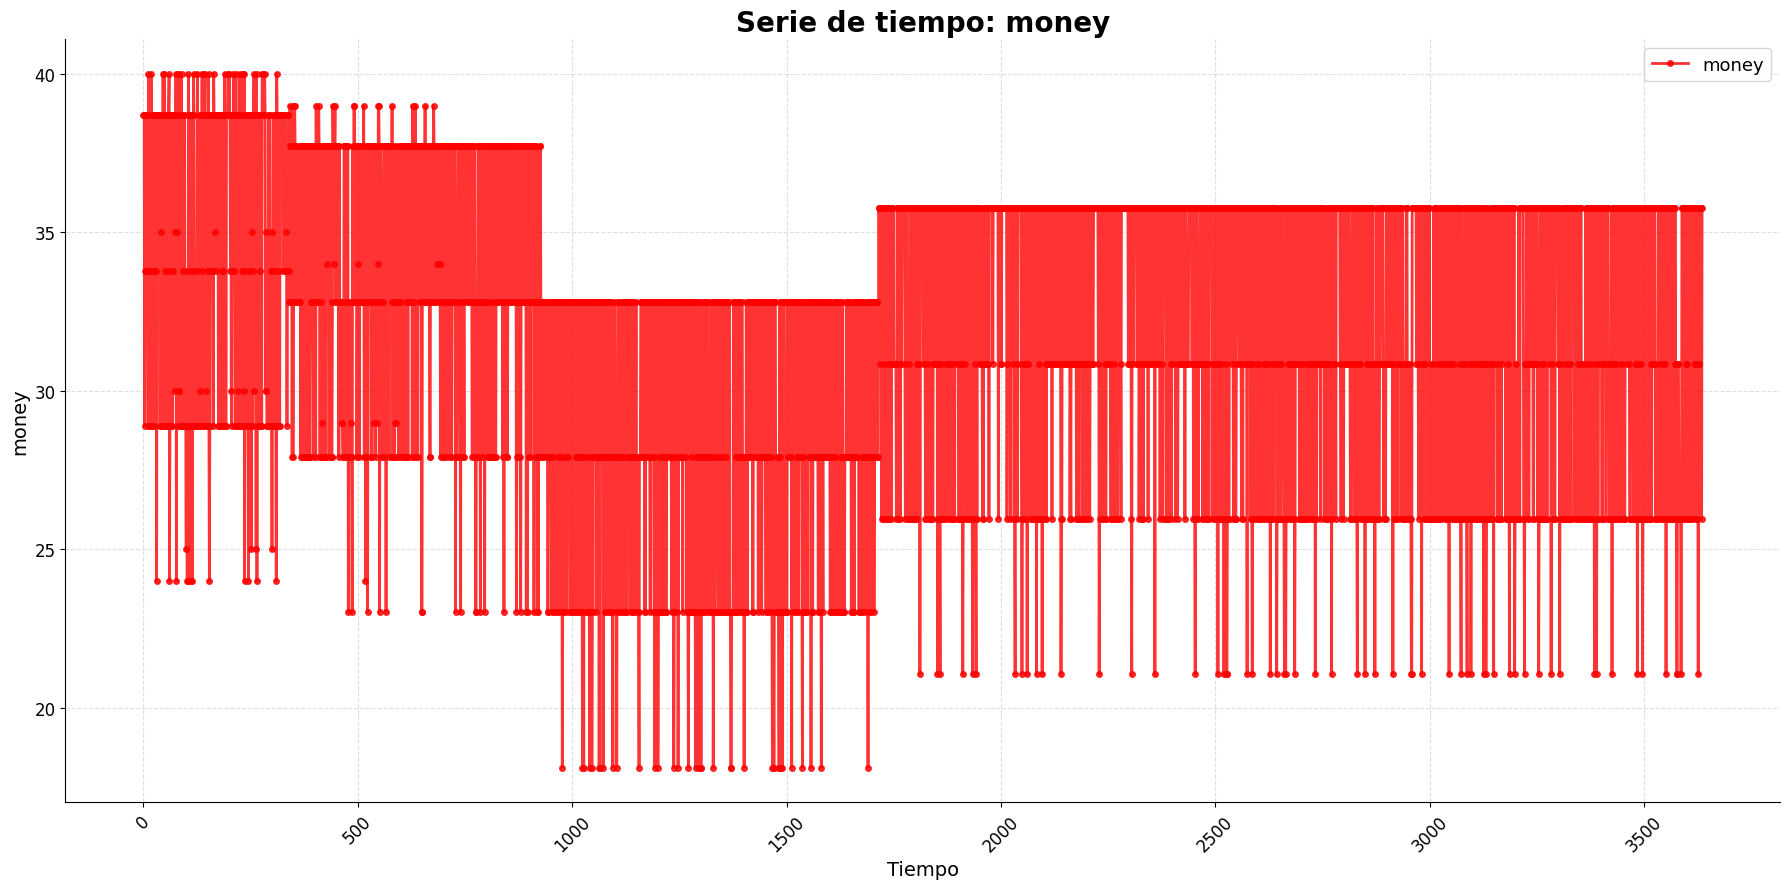

In [3]:
serie = pd.Series(df['money'].values)
graficar_serie(df, 'money', color = 'red')

### Descomponer la Serie

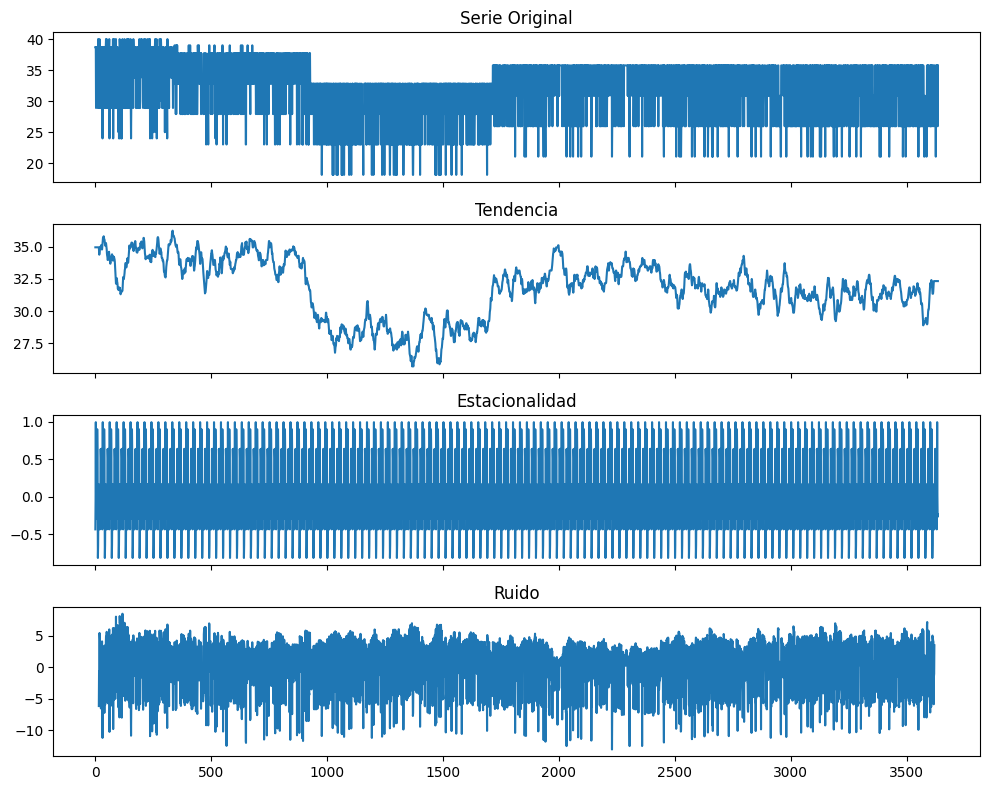

In [4]:
desc = seasonal_decompose(df['money'], model = 'additive', period = 30)

# Definir descomposicion
tendencia = desc.trend
tendencia = tendencia.interpolate(method = 'linear', limit_direction = 'both')
estacionalidad = desc.seasonal
ruido = desc.resid

# Graficar la descomposición
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

df['money'].plot(ax=ax1, title='Serie Original')
tendencia.plot(ax=ax2, title='Tendencia')
estacionalidad.plot(ax=ax3, title='Estacionalidad')
ruido.plot(ax=ax4, title='Ruido')

plt.tight_layout()
plt.show()
plt.close()

### Repartir la desocmposición para Ventana y Ruido

In [5]:
print(f'shape serie          : {serie.shape}')
print(f'shape tendencia      : {tendencia.shape}')
print(f'shape estacionalidad : {estacionalidad.shape}')
print(f'shape ruido          : {ruido.shape}')

shape serie          : (3636,)
shape tendencia      : (3636,)
shape estacionalidad : (3636,)
shape ruido          : (3636,)


In [6]:
ventana = serie[:-30].squeeze()
horizonte = serie[-30:].squeeze()

tendencia_v = tendencia[:-30]
tendencia_h = tendencia[-30:]
estacionalidad_v = estacionalidad[:-30]
estacionalidad_h = estacionalidad[-30:]
ruido_v = ruido[:-30]
ruido_h = ruido[-30:]

print(f'shape ventana                  : {ventana.shape}')
print(f'shape horizonte                : {horizonte.shape}')
print('')
print(f'shape tendencia ventana        : {tendencia_v.shape}')
print(f'shape tendencia horizonte      : {tendencia_h.shape}')
print(f'shape estacionalidad ventana   : {estacionalidad_v.shape}')
print(f'shape estacionalidad horizonte : {estacionalidad_h.shape}')
print(f'shape ruido ventana            : {ruido_v.shape}')
print(f'shape ruido horizonte          : {ruido_h.shape}')

shape ventana                  : (3606,)
shape horizonte                : (30,)

shape tendencia ventana        : (3606,)
shape tendencia horizonte      : (30,)
shape estacionalidad ventana   : (3606,)
shape estacionalidad horizonte : (30,)
shape ruido ventana            : (3606,)
shape ruido horizonte          : (30,)


### Restar a la ventana su parte de tendencia

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
shape ventana   : (3606,)
shape tendencia : (3606,)
shape simple    : (3606, 1)


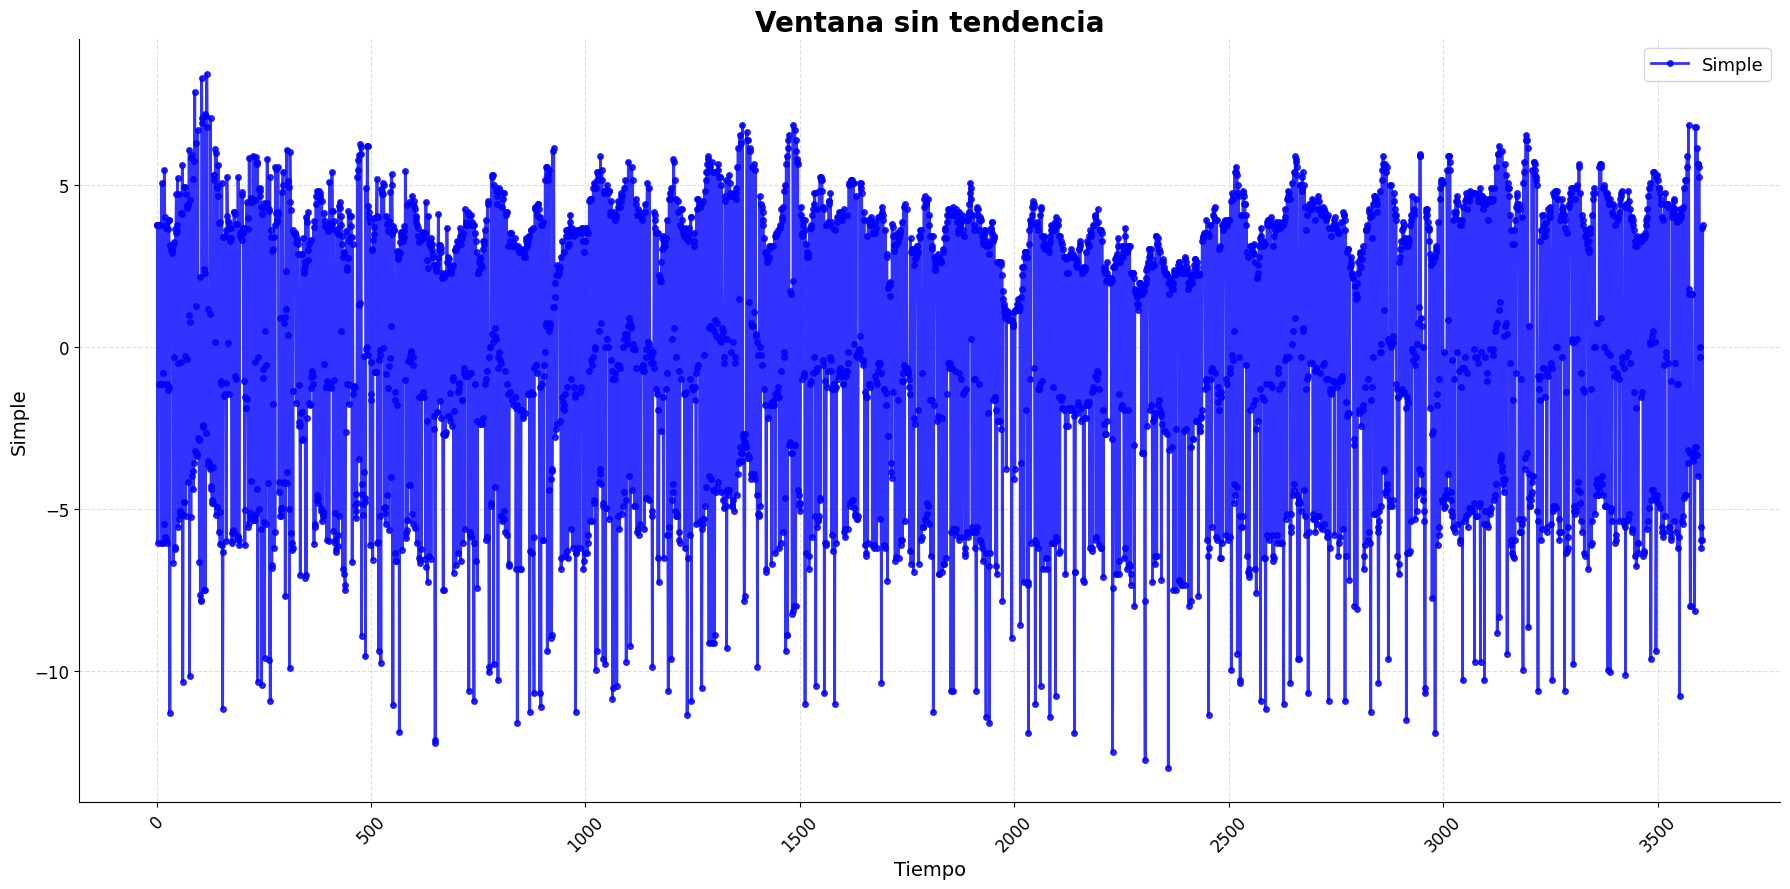

In [ ]:
simple = ventana - tendencia_v
simple = pd.DataFrame(simple, columns = ['Simple'])

print(type(ventana))
print(type(tendencia))
print(type(simple))
 
print(f'shape ventana   : {ventana.shape}')
print(f'shape tendencia : {tendencia_v.shape}')
print(f'shape simple    : {simple.shape}')
graficar_serie(simple, 'Simple', color = 'blue', titulo = 'Ventana sin tendencia')

### Experimento


 Modelo ARIMA(2,2,20) entrenado exitosamente

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3606
Model:              SARIMAX(2, 2, 20)   Log Likelihood              -10261.218
Date:                Tue, 04 Nov 2025   AIC                          20568.435
Time:                        11:01:15   BIC                          20710.666
Sample:                             0   HQIC                         20619.135
                               - 3606                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8853      0.538     -1.645      0.100      -1.940       0.169
ar.L2         -0.4738      0.348     -1.361      0.174      -1.156       0.209
ma.L1

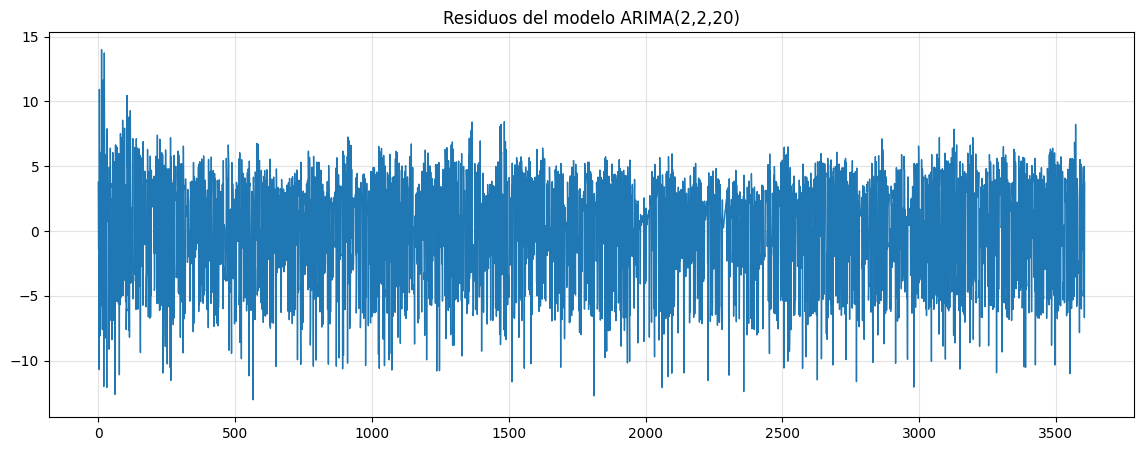

<Figure size 1400x400 with 0 Axes>

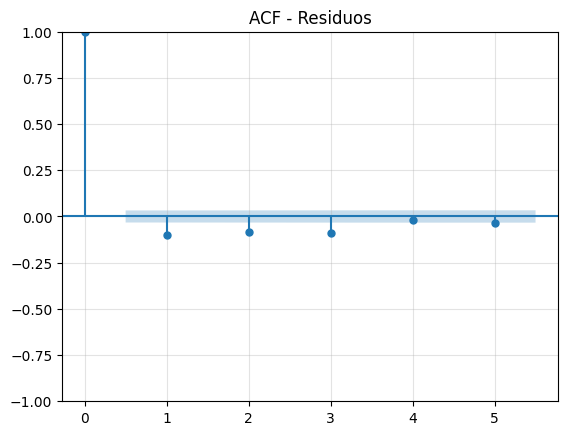

<Figure size 1400x400 with 0 Axes>

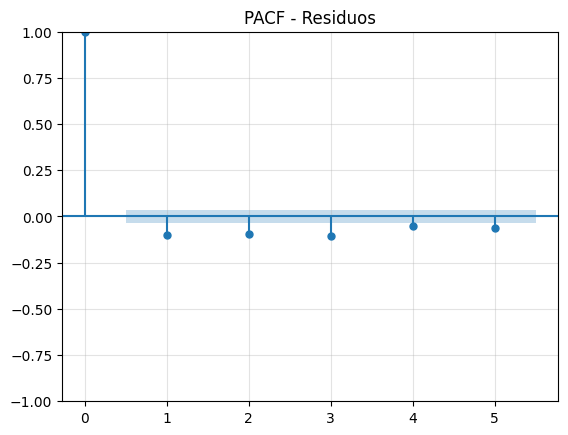


 Test de Ljung - Box ¿Es ruido blanco?

     lb_stat     lb_pvalue
1  34.484823  4.295880e-09
2  60.759380  6.401303e-14
3  87.910540  6.155848e-19
4  89.281414  1.871284e-18
5  93.343177  1.332328e-18

 Interpretacion de la Hipótesis nula

Lag 1: Rechaza Ho, acepta H1 -- Hay correlación en los residuos
Lag 2: Rechaza Ho, acepta H1 -- Hay correlación en los residuos
Lag 3: Rechaza Ho, acepta H1 -- Hay correlación en los residuos
Lag 4: Rechaza Ho, acepta H1 -- Hay correlación en los residuos
Lag 5: Rechaza Ho, acepta H1 -- Hay correlación en los residuos


In [8]:
serie = pd.Series(simple['Simple'].values, index=ventana.index)
p = 2
d = 2
q = 20
resultado, residuos = ARIMA_experimento(serie, p, d, q, 5)

### Forecast

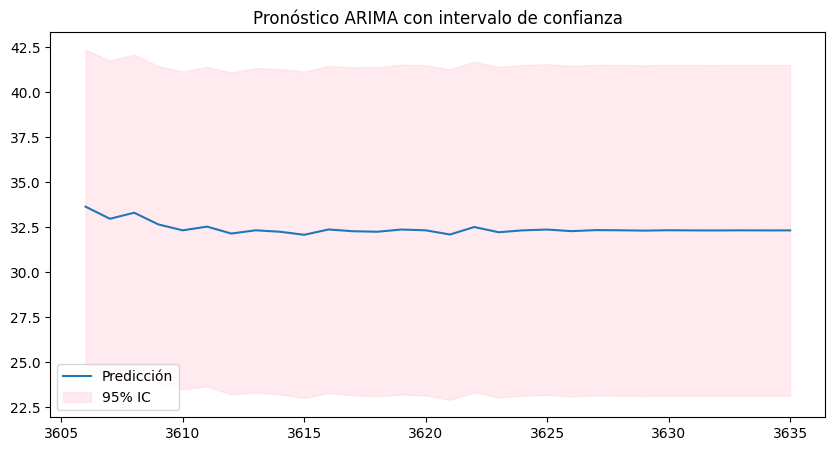

In [9]:
forecast_obj = resultado.get_forecast(steps=len(horizonte))

# Extraer la media predicha y alinear índices
forecast_std = forecast_obj.predicted_mean
forecast_std.index = horizonte.index

# Regresar el forecast a la escala de el horizonte
forecast_reescalado = forecast_std + tendencia_h

# Extraer intervalo de confianza directamente del objeto
intervalo = forecast_obj.conf_int(alpha=0.05)
intervalo.index = horizonte.index  # alinear índices con tu horizonte
intervalo = intervalo + tendencia_h.values.reshape(-1, 1)

# Graficar
plt.figure(figsize=(10,5))
plt.plot(forecast_reescalado, label='Predicción')
plt.fill_between(intervalo.index, intervalo.iloc[:, 0], intervalo.iloc[:, 1],
                 color='pink', alpha=0.3, label='95% IC')
plt.legend()
plt.title('Pronóstico ARIMA con intervalo de confianza')
plt.show()

### Evaluar Forecast

In [10]:
y_true = np.array(horizonte.values).flatten()
y_pred = np.array(forecast_reescalado).flatten()

print(f'shape Y_True : {y_true.shape}')
print(f'shape Y_Pred : {y_pred.shape}')

medidas = evaluar_forecast(y_true, y_pred)

for nombre, valor in medidas.items():
    print(f'{nombre} : {np.round(valor, 4)}')

shape Y_True : (30,)
shape Y_Pred : (30,)
RMSE : 4.4382
SMAPE : 12.4034
R2_Pearson : 0.0022


### Graficar

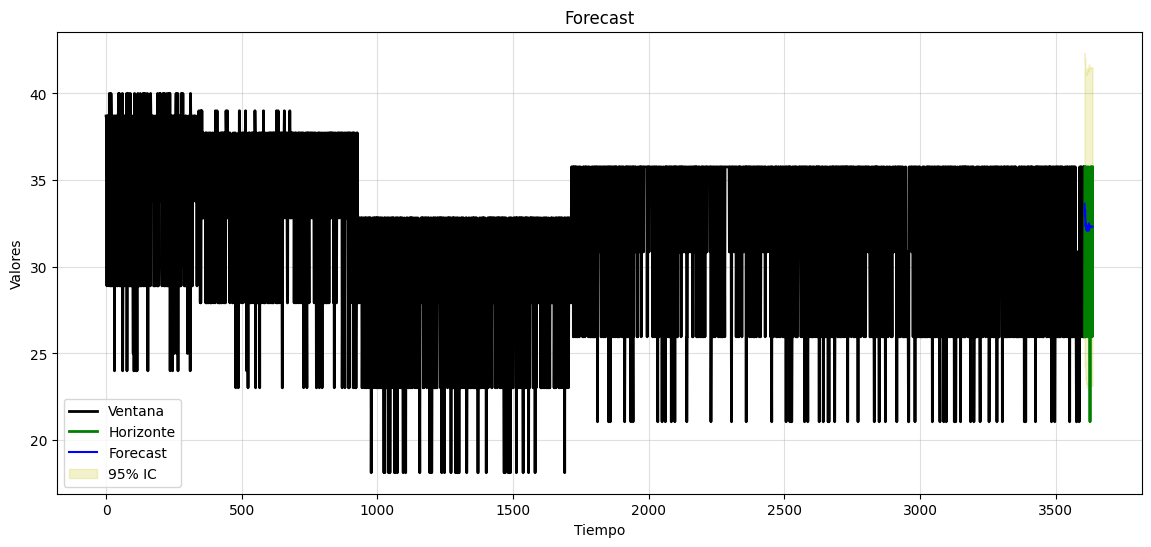

In [11]:
n_ventana = len(ventana)
n_horizonte = len(horizonte)
idx_ventana = np.arange(n_ventana)
idx_horizonte = np.arange(n_ventana, n_ventana + n_horizonte)

plt.figure(figsize=(14,6))
plt.plot(idx_ventana, ventana.values, label='Ventana', color='black', linewidth=2)
plt.plot(idx_horizonte, horizonte.values, label='Horizonte', color='green', linewidth=2)
plt.plot(idx_horizonte, forecast_reescalado, label='Forecast', color='b', linewidth=1.5)

plt.fill_between(intervalo.index, intervalo.iloc[:, 0], intervalo.iloc[:, 1],
                 color='y', alpha=0.2, label='95% IC')

plt.xlabel('Tiempo')
plt.ylabel('Valores')
plt.title('Forecast')
plt.legend()
plt.grid(alpha=0.4)
plt.show()